In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score


In [43]:
df = pd.read_csv('churn.csv')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)


In [69]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [45]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print("------------")


CreditScore
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 709 705 56

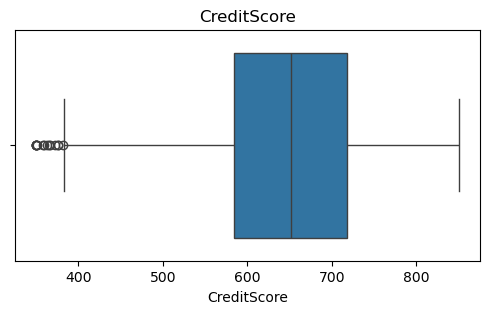

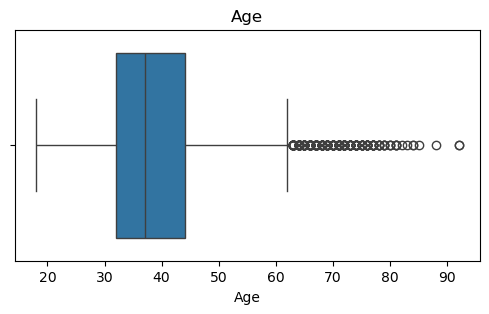

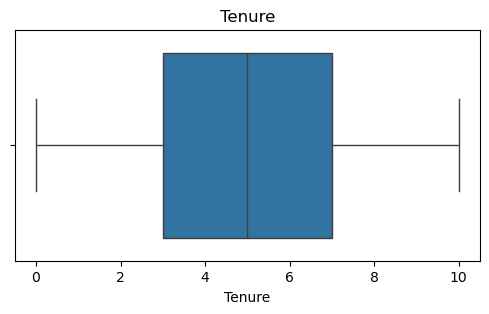

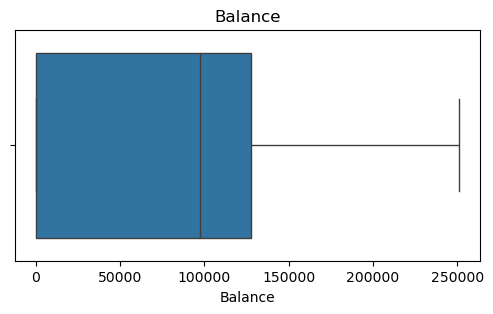

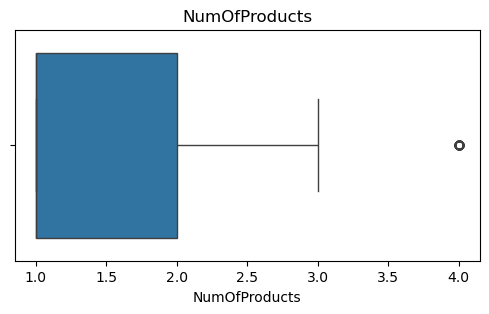

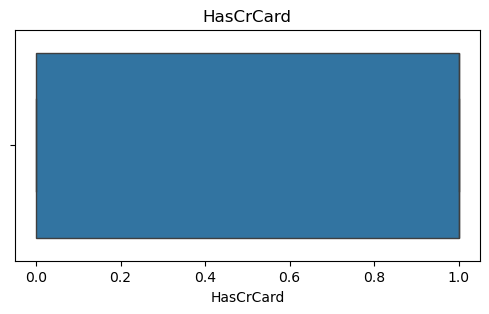

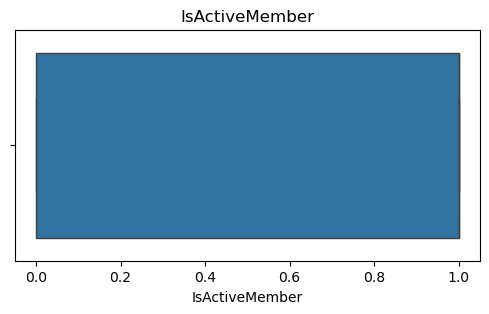

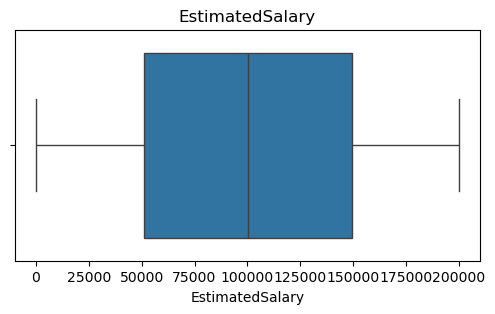

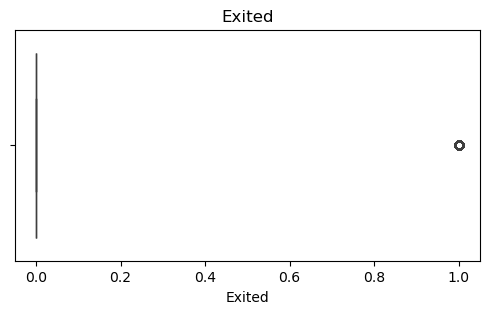

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


In [47]:
import numpy as np

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]

    print(f"Column: {col}")
    print(f"Number of Outliers: {outliers.shape[0]}")
    print("--------------")


Column: CreditScore
Number of Outliers: 15
--------------
Column: Age
Number of Outliers: 359
--------------
Column: Tenure
Number of Outliers: 0
--------------
Column: Balance
Number of Outliers: 0
--------------
Column: NumOfProducts
Number of Outliers: 60
--------------
Column: HasCrCard
Number of Outliers: 0
--------------
Column: IsActiveMember
Number of Outliers: 0
--------------
Column: EstimatedSalary
Number of Outliers: 0
--------------
Column: Exited
Number of Outliers: 2037
--------------


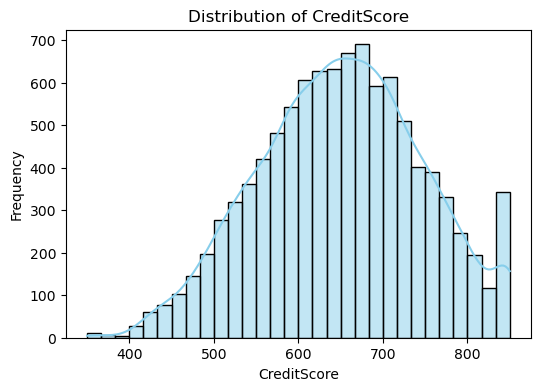

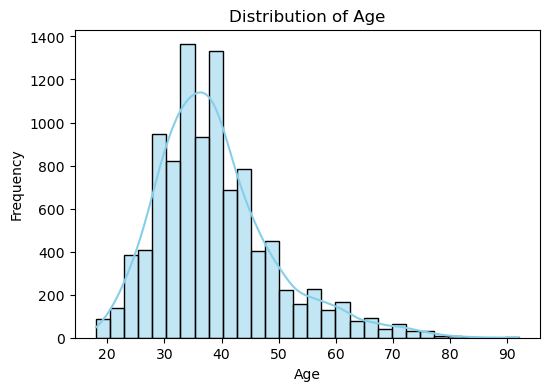

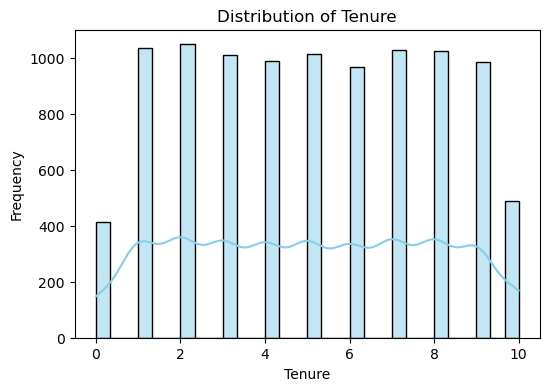

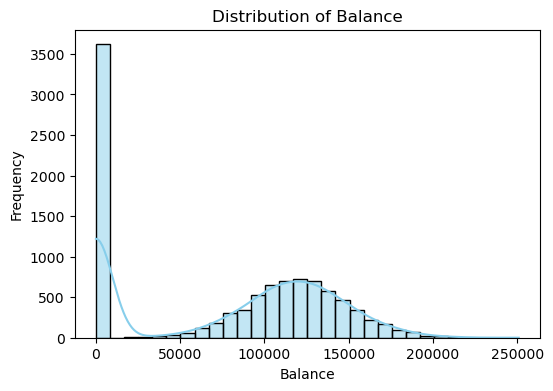

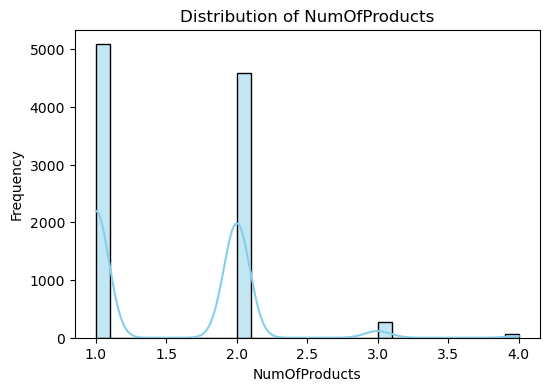

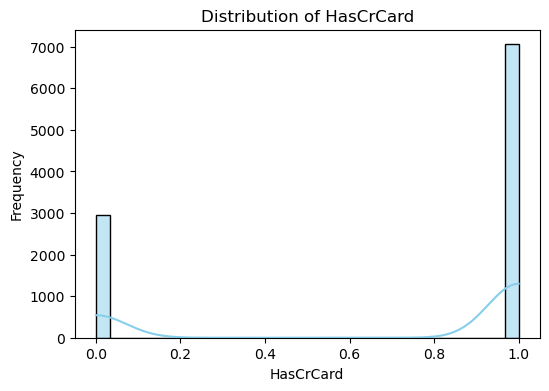

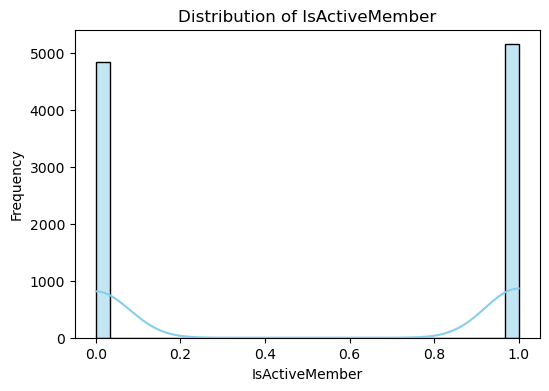

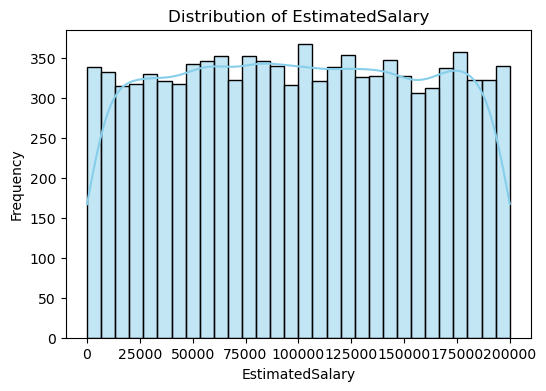

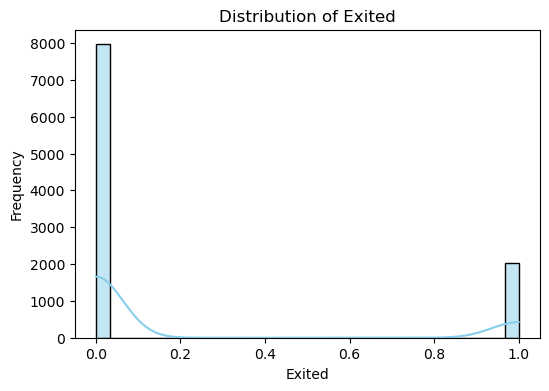

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [49]:
X = df.drop('Exited', axis=1)
y = df['Exited']

le_geo = LabelEncoder()
le_gen = LabelEncoder()
X['Geography'] = le_geo.fit_transform(X['Geography'])
X['Gender'] = le_gen.fit_transform(X['Gender'])

In [50]:
le_gen.inverse_transform([0 , 1 ])

array(['Female', 'Male'], dtype=object)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [52]:
from sklearn.linear_model import LogisticRegression
x_train_scaled=x_train.copy()
x_test_scaled=x_test.copy()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
num_cols=['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
x_train_scaled[num_cols]=scaler.fit_transform(x_train[num_cols])
x_test_scaled[num_cols]=scaler.transform(x_test[num_cols])
model=LogisticRegression()
model.fit(x_train_scaled,y_train)
y_pred=model.predict(x_test_scaled)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.14      0.23       407

    accuracy                           0.81      2000
   macro avg       0.70      0.56      0.56      2000
weighted avg       0.77      0.81      0.75      2000



In [54]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import accuracy_score, classification_report


smote = BorderlineSMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

print("Shape after SMOTE:")
print("X_train:", x_train_smote.shape)
print("y_train:", y_train_smote.shape)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train_smote, y_train_smote)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Shape after SMOTE:
X_train: (12740, 10)
y_train: (12740,)
Accuracy: 0.727

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1593
           1       0.39      0.62      0.48       407

    accuracy                           0.73      2000
   macro avg       0.64      0.69      0.65      2000
weighted avg       0.78      0.73      0.75      2000



In [55]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(x_train_smote,y_train_smote)
y_pred=model.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1593
           1       0.54      0.63      0.58       407

    accuracy                           0.81      2000
   macro avg       0.72      0.74      0.73      2000
weighted avg       0.83      0.81      0.82      2000



enhance imbalnce

In [56]:
X['BalancePerProduct'] = X['Balance'] / (X['NumOfProducts'] + 1)
X['TenureAgeRatio'] = X['Tenure'] / (X['Age'] + 1)
X['CreditScore_Age'] = X['CreditScore'] * X['Age']
X['IsActiveMember_HasCrCard'] = X['IsActiveMember'] * X['HasCrCard']
X['BalanceSalaryRatio'] = X['Balance'] / (X['EstimatedSalary'] + 1)
X['AgeGroup'] = pd.cut(X['Age'], bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(int)
X['BalanceZero'] = (X['Balance'] == 0).astype(int)
X['TenureByAge'] = X['Tenure'] / X['Age']
X['CreditScoreNormalized'] = X['CreditScore'] / 850
X['NumOfProducts_IsActiveMember'] = X['NumOfProducts'] * X['IsActiveMember']
X['Balance_Geography'] = X['Balance'] * X['Geography']
X['Age_Geography'] = X['Age'] * X['Geography']
X['Age_IsActiveMember'] = X['Age'] * X['IsActiveMember']
X['Gender_IsActiveMember'] = X['Gender'] * X['IsActiveMember']
X['Tenure_IsActiveMember'] = X['Tenure'] * X['IsActiveMember']
X['Balance_IsActiveMember'] = X['Balance'] * X['IsActiveMember']
X['CreditScore_Gender'] = X['CreditScore'] * X['Gender']
X['Age_Gender'] = X['Age'] * X['Gender']
X['NumProducts_Geography'] = X['NumOfProducts'] * X['Geography']
X['Age_Squared'] = X['Age'] ** 2
X['Balance_Squared'] = X['Balance'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['BalanceBin'] = pd.cut(X['Balance'], bins=5, labels=[0,1,2,3,4]).astype(int)
X['TenureBin'] = pd.cut(X['Tenure'], bins=5, labels=[0,1,2,3,4]).astype(int)
X['SalaryBin'] = pd.cut(X['EstimatedSalary'], bins=5, labels=[0,1,2,3,4]).astype(int)
X['RiskScore'] = (X['Age'] / 100) * (1 - X['IsActiveMember']) * (X['NumOfProducts'] <= 2).astype(int)
X['LoyaltyScore'] = X['Tenure'] * X['IsActiveMember'] * X['HasCrCard']
X['EngagementScore'] = X['IsActiveMember'] * X['NumOfProducts'] * (X['Balance'] > 0).astype(int)
X['HighValueCustomer'] = ((X['Balance'] > X['Balance'].quantile(0.75)) & (X['EstimatedSalary'] > X['EstimatedSalary'].quantile(0.75))).astype(int)
X['AtRiskCustomer'] = ((X['Age'] > 50) & (X['IsActiveMember'] == 0) & (X['NumOfProducts'] <= 1)).astype(int)
X['Age_Balance_Active'] = X['Age'] * X['Balance'] * X['IsActiveMember'] / 100000
X['Tenure_Products_Geography'] = X['Tenure'] * X['NumOfProducts'] * X['Geography']
X['Credit_Age_Gender'] = X['CreditScore'] * X['Age'] * X['Gender'] / 1000
print(f"Total features: {X.shape[1]}")

Total features: 44


In [57]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [58]:
print("\nApplying SMOTETomek...")
smt = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(x_train, y_train)
print(f"After SMOTETomek: {X_train_resampled.shape}")



Applying SMOTETomek...
After SMOTETomek: (10204, 44)


In [59]:
#use random search on only them cuz they are sensitive to HP Not like RF or Cat
xgb_params = {
    'n_estimators': [500, 800, 1000, 1200],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'gamma': [0.1, 0.2, 0.3],
    'reg_alpha': [0.1, 0.3, 0.5],
    'reg_lambda': [1.0, 2.0, 3.0]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=2, eval_metric='logloss'),
    param_distributions=xgb_params,
    n_iter=30,
    cv=3,
    scoring='f1',
    n_jobs=2,
    random_state=42,
    verbose=1
)
xgb_search.fit(X_train_resampled, y_train_resampled)
print(f"Best XGBoost F1: {xgb_search.best_score_:.4f}")
print(f"Best params: {xgb_search.best_params_}")


lgbm_params = {
    'n_estimators': [500, 800, 1000, 1200],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'num_leaves': [30, 50, 70],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [20, 30, 40],
    'reg_alpha': [0.1, 0.3, 0.5],
    'reg_lambda': [1.0, 2.0, 3.0]
}

lgbm_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, n_jobs=2, verbose=-1),
    param_distributions=lgbm_params,
    n_iter=30,
    cv=3,
    scoring='f1',
    n_jobs=2,
    random_state=42,
    verbose=1
)
lgbm_search.fit(X_train_resampled, y_train_resampled)
print(f" Best LightGBM F1: {lgbm_search.best_score_:.4f}")
print(f" Best params: {lgbm_search.best_params_}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost F1: 0.8301
Best params: {'subsample': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
 Best LightGBM F1: 0.8301
 Best params: {'subsample': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'num_leaves': 30, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [60]:
xgb_optimized = xgb_search.best_estimator_
y_pred_proba_xgb = xgb_optimized.predict_proba(X_test)[:, 1]

lgbm_optimized = lgbm_search.best_estimator_
y_pred_proba_lgbm = lgbm_optimized.predict_proba(X_test)[:, 1]

catboost_model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.02,
                                    l2_leaf_reg=3, random_state=42, verbose=0, thread_count=2)
catboost_model.fit(X_train_resampled, y_train_resampled)
y_pred_proba_cat = catboost_model.predict_proba(X_test)[:, 1]

rf_model = RandomForestClassifier(n_estimators=700, max_depth=30, min_samples_split=2,
                                 class_weight='balanced', random_state=42, n_jobs=2)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]


In [61]:
base_models = [
    ('xgb', xgb_optimized),
    ('lgbm', lgbm_optimized),
    ('catboost', catboost_model),
    ('rf', rf_model)
]
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(C=0.1, max_iter=2000, random_state=42),
    cv=7,
    n_jobs=2
)
stacking_model.fit(X_train_resampled, y_train_resampled)
y_pred_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

In [62]:
weights = {
    'xgb': 0.28,
    'lgbm': 0.28,
    'catboost': 0.26,
    'rf': 0.10,
    'stack': 0.08
}

y_pred_proba_weighted = (
    weights['xgb'] * y_pred_proba_xgb +
    weights['lgbm'] * y_pred_proba_lgbm +
    weights['catboost'] * y_pred_proba_cat +
    weights['rf'] * y_pred_proba_rf +
    weights['stack'] * y_pred_proba_stack
)

In [63]:

models_proba = {
    'XGBoost_Optimized': y_pred_proba_xgb,
    'LightGBM_Optimized': y_pred_proba_lgbm,
    'CatBoost': y_pred_proba_cat,
    'RandomForest': y_pred_proba_rf,
    'Stacking_Advanced': y_pred_proba_stack,
    'WeightedEnsemble_Optimized': y_pred_proba_weighted
}

results = []

for model_name, y_proba in models_proba.items():
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.arange(0.20, 0.70, 0.02):
        y_pred_temp = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_temp)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    y_pred_final = (y_proba >= best_threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred_final)
    precision = precision_score(y_test, y_pred_final)
    recall = recall_score(y_test, y_pred_final)
    f1 = f1_score(y_test, y_pred_final)
    roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred_final)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    results.append({
        'Model': model_name, 'Threshold': best_threshold, 'Accuracy': acc,
        'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    })
    
    print(f"\n{model_name}:")
    print(f"   F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"   FN: {fn} | FP: {fp} | Threshold: {best_threshold:.2f}")

results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print(" FINAL COMPARISON")
print("="*80)
print(results_df[['Model', 'Threshold', 'F1-Score', 'Precision', 'Recall', 'FN', 'FP']].to_string(index=False))

best = results_df.iloc[0]
print(f"\n BEST MODEL: {best['Model']}")
print(f"   F1-Score:  {best['F1-Score']:.4f}")
print(f"   Precision: {best['Precision']:.4f}")
print(f"   Recall:    {best['Recall']:.4f}")
print(f"   Missed only {int(best['FN'])} churners out of 407!")


XGBoost_Optimized:
   F1: 0.6215 | Precision: 0.5668 | Recall: 0.6880
   FN: 127 | FP: 214 | Threshold: 0.34

LightGBM_Optimized:
   F1: 0.6287 | Precision: 0.6334 | Recall: 0.6241
   FN: 153 | FP: 147 | Threshold: 0.44

CatBoost:
   F1: 0.6020 | Precision: 0.6176 | Recall: 0.5872
   FN: 168 | FP: 148 | Threshold: 0.40

RandomForest:
   F1: 0.6140 | Precision: 0.5678 | Recall: 0.6683
   FN: 135 | FP: 207 | Threshold: 0.40

Stacking_Advanced:
   F1: 0.6136 | Precision: 0.5460 | Recall: 0.7002
   FN: 122 | FP: 237 | Threshold: 0.28

WeightedEnsemble_Optimized:
   F1: 0.6205 | Precision: 0.5685 | Recall: 0.6830
   FN: 129 | FP: 211 | Threshold: 0.34

 FINAL COMPARISON
                     Model  Threshold  F1-Score  Precision   Recall  FN  FP
        LightGBM_Optimized       0.44  0.628713   0.633416 0.624079 153 147
         XGBoost_Optimized       0.34  0.621532   0.566802 0.687961 127 214
WeightedEnsemble_Optimized       0.34  0.620536   0.568507 0.683047 129 211
              RandomF

In [74]:
import pandas as pd
from tabulate import tabulate

results_df = pd.DataFrame(results)

results_df = results_df.sort_values('Recall', ascending=False)

best = results_df.iloc[0]

print("\nFINAL COMPARISON TABLE:")
print(tabulate(
    results_df[['Model', 'Threshold', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'FN', 'FP']],
    headers='keys', tablefmt='fancy_grid', showindex=False,
    floatfmt=(".2f", ".4f", ".4f", ".4f", ".4f", ".4f", ".0f", ".0f")
))


print(f"\nBEST MODEL: {best['Model']}")
print(f"   Accuracy:  {best['Accuracy']:.4f}")
print(f"   F1-Score:  {best['F1-Score']:.4f}")
print(f"   Precision: {best['Precision']:.4f}")
print(f"   Recall:    {best['Recall']:.4f}")
print(f"   Missed only {int(best['FN'])} churners out of {y_test.sum()}!")



FINAL COMPARISON TABLE:
╒════════════════════════════╤═════════════╤════════════╤════════════╤═════════════╤══════════╤══════╤══════╕
│ Model                      │   Threshold │   Accuracy │   F1-Score │   Precision │   Recall │   FN │   FP │
╞════════════════════════════╪═════════════╪════════════╪════════════╪═════════════╪══════════╪══════╪══════╡
│ Stacking_Advanced          │      0.2800 │     0.8205 │     0.6136 │      0.5460 │   0.7002 │  122 │  237 │
├────────────────────────────┼─────────────┼────────────┼────────────┼─────────────┼──────────┼──────┼──────┤
│ XGBoost_Optimized          │      0.3400 │     0.8295 │     0.6215 │      0.5668 │   0.6880 │  127 │  214 │
├────────────────────────────┼─────────────┼────────────┼────────────┼─────────────┼──────────┼──────┼──────┤
│ WeightedEnsemble_Optimized │      0.3400 │     0.8300 │     0.6205 │      0.5685 │   0.6830 │  129 │  211 │
├────────────────────────────┼─────────────┼────────────┼────────────┼─────────────┼──────────┼